In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import librosa
import librosa.display
from scipy.signal import find_peaks
import math
import os
from scipy.signal import butter, sosfilt, sosfreqz

In [4]:
# Real Cough Timestamps of the Data

def get_real_timestamps(cough_timestamp):

    timestamp = []
    f = open(cough_timestamp, "r")
    content = f.read()
    content = content.split("\n")

    for line in content:
        if line != "":
            timestamp.append(float(line.split("\t")[0]))
    
    return timestamp

In [5]:
# Filtering of the data

def butter_bandpass(lowcut, highcut, fs, order=5):
        nyq = 0.5 * fs
        low = lowcut / nyq
        high = highcut / nyq
        sos = butter(order, [low, high], analog=False, btype='band', output='sos')
        return sos

def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
        sos = butter_bandpass(lowcut, highcut, fs, order=order)
        y = sosfilt(sos, data)
        return y

In [6]:
# Moving Average of the Data:
def compute_moving_average(data, window_size=15):
    
    moving_averages = []

    i = 0
    while i < len(data) - window_size + 1:
        
        window = data[i : i + window_size]
        window_average = round(np.sum(window) / window_size, 2)
        moving_averages.append(window_average)

        i += 1    
    
    return np.array(moving_averages)

In [7]:
# Data Normalization

def normalize_data(data):
    min = np.min(data)
    max = np.max(data)

    data = (data - min) / (max - min)
    return data

In [30]:
# Summation of the frequency bins in a spectogram

def get_frequency_sums(data):
    
    sums = []
    S_db_tp = np.transpose(mel_spectrogram_db)

    for bin in S_db_tp:
        sums.append(np.sum(bin))

    sums = np.array(sums)

    return sums

In [26]:
def detect_coughs(data, file_path, percentile_threshold = 90):
    
    # Statistics of the data
    max_value = np.max(data)
    mean_value = np.mean(data)
    std = np.std(data)
    data_length = len(data)
    
    # Threshold 
    threshold = np.percentile(data, percentile_threshold)
    
    # Peak detection
    cough_indices, _ = find_peaks(data, prominence = 5)
    cough_indices = list(cough_indices)

    # Deleting overlaps in the peaks - Avoiding to count same cough more than one
    i = 0
    while i < len(cough_indices):

        peak = cough_indices[i]
        peak_range = (peak - 50, peak + 50) # The range is determined experimentally

        overlap_indices = [index for index in cough_indices
                       if peak_range[0] < index < peak_range[1]]

        if len(overlap_indices) > 1:

            # Find the index with maximum amplitude 
            max = overlap_indices[0]
            for index in overlap_indices:
                if (data[index] > data[max]):
                    max = index

            overlap_indices.remove(max)

            for element in overlap_indices:
                cough_indices.remove(element)

        i += 1

    # Applying the threshold
    
    cough_indices_copy = list(cough_indices)
    for index in cough_indices_copy: 
        amplitude = data[index]
        if amplitude < threshold or amplitude < -9250:
            cough_indices.remove(index)


    # Finding the timestamps of the coughs
    predicted_timestamps = [] 
    for index in cough_indices:
        predicted_timestamps.append(round(index / sample_rate, 6))

    # Scaling timestamps according to original recording duration
    duration = librosa.get_duration(path=file_path)
    
    total_samples = duration * sample_rate
    
    for i in range(len(predicted_timestamps)):
        
        actual_index = total_samples * cough_indices[i] / data_length
        actual_timestamp = round(actual_index / sample_rate, 6)
        
        predicted_timestamps[i] = actual_timestamp
    

    # Filtering the sound after coughing
    for ts in predicted_timestamps:
        match = list((ts_2 for ts_2 in predicted_timestamps if ts < ts_2 < ts + 0.4))
        if len(match) != 0:
            index = predicted_timestamps.index(match[0])
            predicted_timestamps.remove(match[0])
            cough_indices.remove(cough_indices[index])

        
    return cough_indices, predicted_timestamps

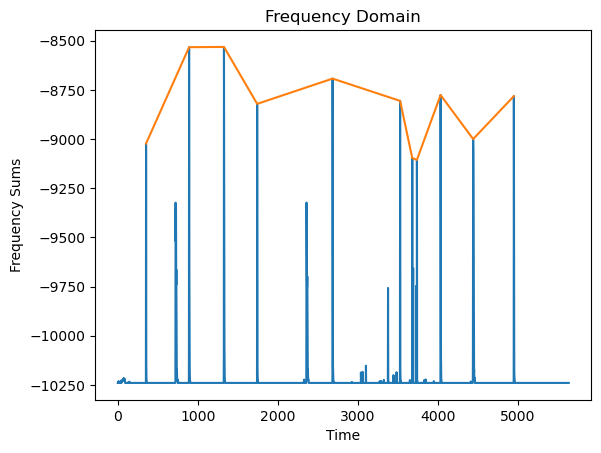


2024-02-09T12-51-43
---------------------
Cough Count: 11
Cough Predicted Timestamps: [3.765297, 9.503908, 14.154529, 18.581153, 28.639722, 37.642302, 39.263619, 39.88228, 43.039583, 47.380874, 52.810154]
Cough Real Timestamps: [7.767075, 25.205261, 47.403537]
Cough Indices: [353, 891, 1327, 1742, 2685, 3529, 3681, 3739, 4035, 4442, 4951]


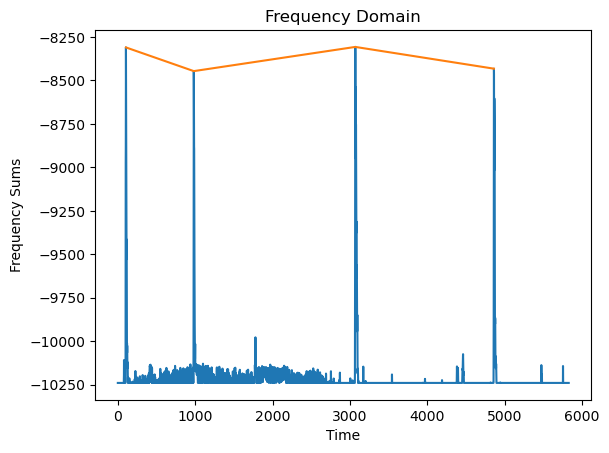


2024-02-19T11-02-25
---------------------
Cough Count: 4
Cough Predicted Timestamps: [1.119989, 10.474561, 32.746338, 51.860812]
Cough Real Timestamps: [1.114558, 10.482698, 32.74662, 51.852581]
Cough Indices: [105, 982, 3070, 4862]


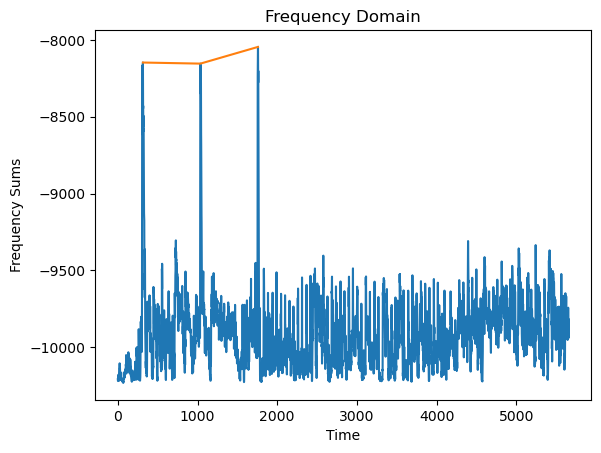


2024-02-11T21-33-49
---------------------
Cough Count: 3
Cough Predicted Timestamps: [3.359813, 11.050053, 18.750958]
Cough Real Timestamps: [3.297234, 11.052698, 18.761723]
Cough Indices: [315, 1036, 1758]


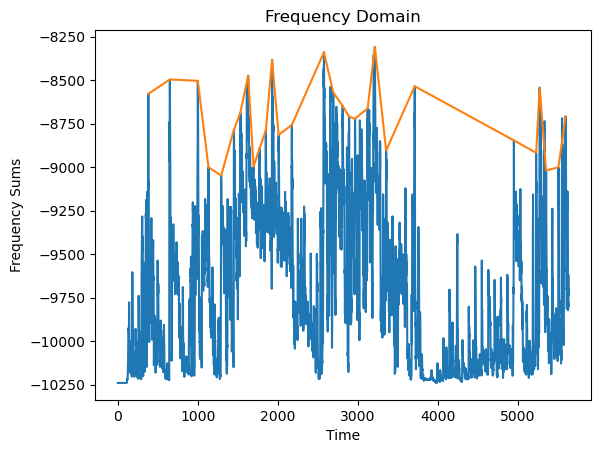


2024-02-09T12-50-14
---------------------
Cough Count: 29
Cough Predicted Timestamps: [4.063749, 6.932905, 10.655342, 12.084588, 13.769817, 15.465712, 16.318993, 17.364262, 18.08955, 18.868169, 19.72145, 20.553398, 21.428011, 23.187902, 27.464972, 28.702229, 29.960818, 30.814098, 31.603383, 33.288612, 34.248553, 35.75246, 39.560225, 52.77541, 55.74056, 56.209865, 57.063145, 58.705711, 59.665651]
Cough Real Timestamps: [4.007188, 6.963311, 12.021565, 23.231565, 27.590476, 39.531973, 45.244082, 56.29678]
Cough Indices: [381, 650, 999, 1133, 1291, 1450, 1530, 1628, 1696, 1769, 1849, 1927, 2009, 2174, 2575, 2691, 2809, 2889, 2963, 3121, 3211, 3352, 3709, 4948, 5226, 5270, 5350, 5504, 5594]


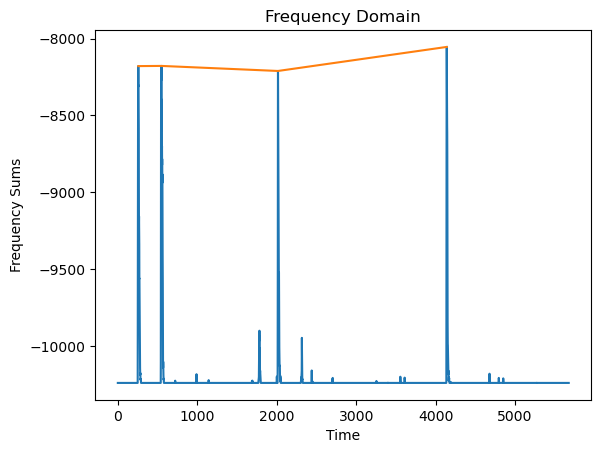


2024-02-11T20-59-47
---------------------
Cough Count: 4
Cough Predicted Timestamps: [2.752011, 5.856024, 21.493422, 44.149516]
Cough Real Timestamps: [2.753457, 5.839819, 21.52703, 44.157959]
Cough Indices: [258, 549, 2015, 4139]


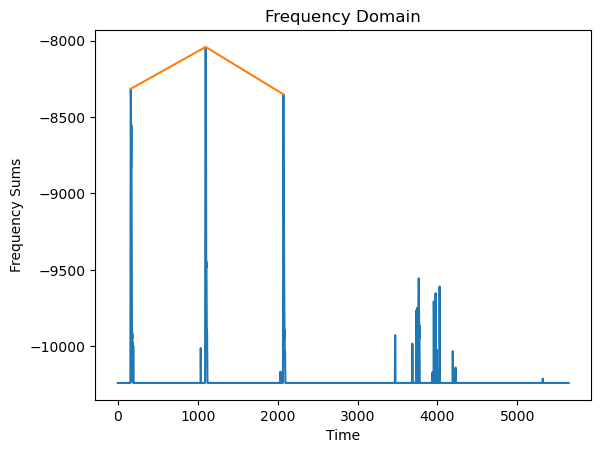


2024-02-15T12-05-33
---------------------
Cough Count: 3
Cough Predicted Timestamps: [1.727991, 11.722606, 22.101219]
Cough Real Timestamps: [1.790415, 11.721125, 22.099867]
Cough Indices: [162, 1099, 2072]


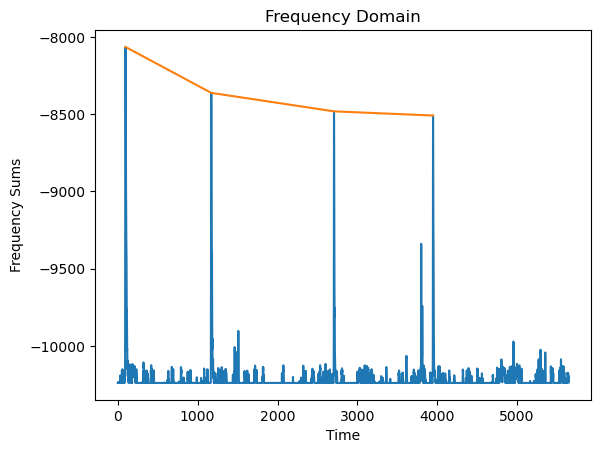


2024-02-19T17-14-26
---------------------
Cough Count: 4
Cough Predicted Timestamps: [1.023847, 12.478135, 28.870352, 42.095043]
Cough Real Timestamps: [1.016298, 12.466887, 28.873712, 42.096383]
Cough Indices: [96, 1170, 2707, 3947]


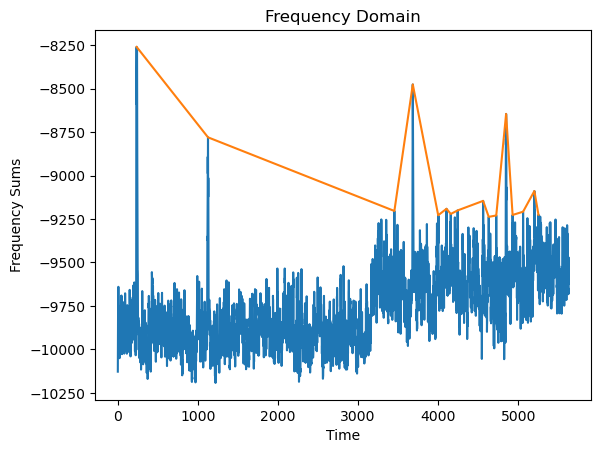


2024-02-09T12-50-58
---------------------
Cough Count: 16
Cough Predicted Timestamps: [2.50644, 12.009579, 36.828666, 39.281777, 42.662804, 43.772037, 44.337319, 45.254569, 48.646262, 49.392861, 50.395437, 51.707319, 52.57124, 53.968447, 55.472311, 56.016262]
Cough Real Timestamps: [2.530975, 11.993107, 39.288163, 51.734059]
Cough Indices: [235, 1126, 3453, 3683, 4000, 4104, 4157, 4243, 4561, 4631, 4725, 4848, 4929, 5060, 5201, 5252]


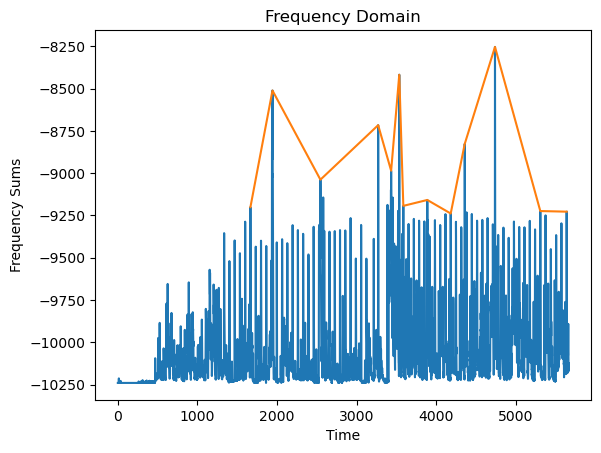


2024-02-09T12-51-30
---------------------
Cough Count: 13
Cough Predicted Timestamps: [17.758897, 20.713381, 27.134315, 34.867169, 36.605727, 37.69366, 38.237626, 41.448093, 44.583899, 46.461115, 50.514197, 56.583154, 60.113601]
Cough Real Timestamps: [20.68898, 26.999365, 27.527256, 41.506032]
Cough Indices: [1665, 1942, 2544, 3269, 3432, 3534, 3585, 3886, 4180, 4356, 4736, 5305, 5636]


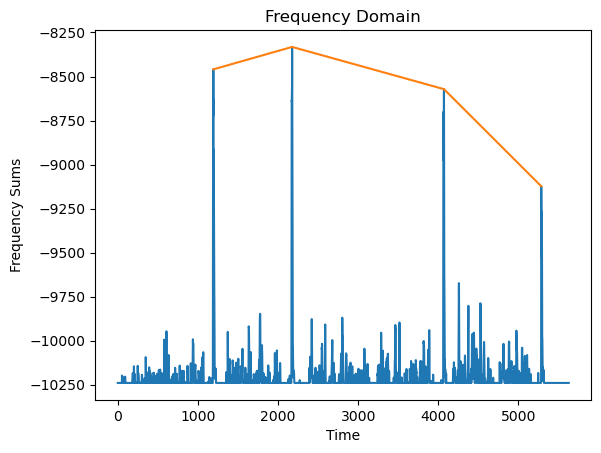


2024-02-09T12-50-40
---------------------
Cough Count: 4
Cough Predicted Timestamps: [12.71355, 23.197963, 43.409522, 56.357718]
Cough Real Timestamps: [12.701315, 23.161905, 43.398095, 56.42449]
Cough Indices: [1192, 2175, 4070, 5284]


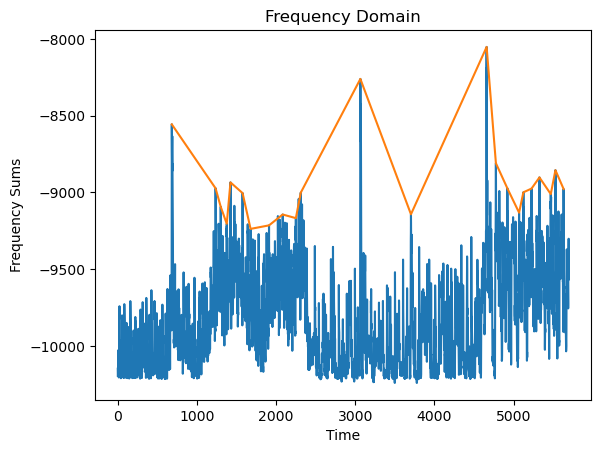


2024-02-09T12-51-12
---------------------
Cough Count: 23
Cough Predicted Timestamps: [7.273559, 13.171328, 13.864556, 14.675099, 15.176356, 16.808108, 17.885277, 20.370232, 22.215285, 23.985682, 24.646914, 32.677692, 39.492654, 49.688435, 50.936245, 52.482677, 54.061103, 54.637015, 55.735515, 56.802019, 58.32712, 58.956358, 60.054857]
Cough Real Timestamps: [7.325896, 32.716916, 49.690703]
Cough Indices: [682, 1235, 1300, 1376, 1423, 1576, 1677, 1910, 2083, 2249, 2311, 3064, 3703, 4659, 4776, 4921, 5069, 5123, 5226, 5326, 5469, 5528, 5631]


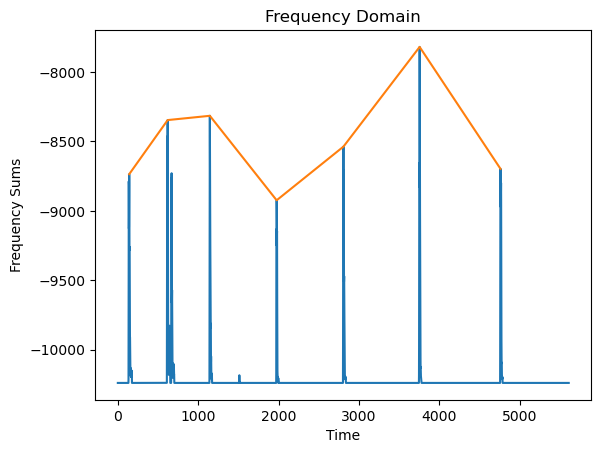


2024-02-09T11-36-08
---------------------
Cough Count: 7
Cough Predicted Timestamps: [1.51456, 6.612866, 12.21247, 21.075844, 29.939218, 40.050503, 50.780412]
Cough Real Timestamps: [1.516739, 6.591125, 7.126444, 12.228711, 21.089368, 29.944449, 40.043033, 50.816343]
Cough Indices: [142, 620, 1145, 1976, 2807, 3755, 4761]


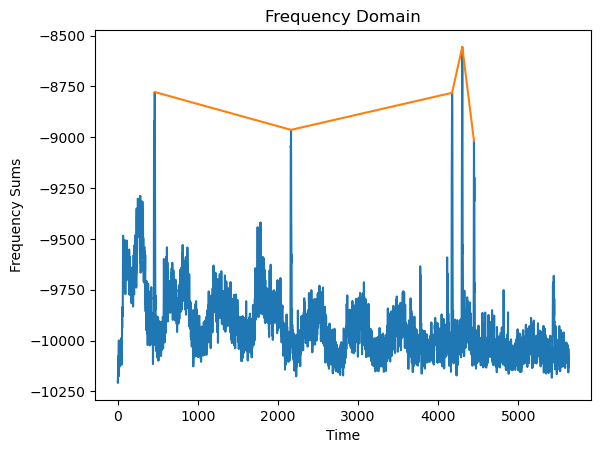


2024-02-09T12-52-22
---------------------
Cough Count: 5
Cough Predicted Timestamps: [4.916741, 23.058557, 44.506642, 45.861145, 47.418291]
Cough Real Timestamps: [4.8878, 23.045805, 44.501043, 45.83619, 47.415147]
Cough Indices: [461, 2162, 4173, 4300, 4446]


In [27]:
audio_files = os.listdir('../audio-records/cough')
timestamp_files = os.listdir('../audio-records/cough-timestamps')
all_timestamp_data = dict()

# Removing irrelevant files
for file in audio_files.copy():
    if not file.endswith('.wav'):
        audio_files.remove(file)

for file in timestamp_files.copy():
     if not file.endswith('.txt'):
        timestamp_files.remove(file)   

for file in audio_files:

    file_name = file.split(".wav")[0]    
    timestamp_files = [file[0:19] for file in timestamp_files]    

    # Finding correspoding timestamp file
    index = timestamp_files.index(file_name)
    timestamp_data = timestamp_files[index]
    
    file_path = '../audio-records/cough/' + file
    timestamp_path = '../audio-records/cough-timestamps/' + timestamp_data + '-label.txt'

    # Adding timestamps to the list
    real_timestamps = get_real_timestamps(timestamp_path)      
    
    # Loading audio_file
    # Target sample rate: 48000
    data, sample_rate = librosa.load(file_path, sr=48000)

    # Audio duration
    duration = librosa.get_duration(path = file_path)
    total_samples = duration * sample_rate
    time = np.arange(0, len(data)) / sample_rate

    # Filtering data
    data = butter_bandpass_filter(data, 1000, 4000, sample_rate,8)

    # Getting moving average of the data
    moving_avg_data = compute_moving_average(np.abs(data))

    # Normalize the data
    normalized_moving_avg_data = normalize_data(moving_avg_data)
    
    # Getting melspectrogram
    mel_spectrogram = librosa.feature.melspectrogram(y=normalized_moving_avg_data, sr=sample_rate)
    mel_spectrogram_db = librosa.amplitude_to_db(mel_spectrogram, ref=np.max)    

    frequency_sums = get_frequency_sums(mel_spectrogram_db)
    
    # Cough detection
    cough_indices , predicted_timestamps = detect_coughs(frequency_sums, file_path)

    # Adding predicted and real timestamp tuples to the list
    all_timestamp_data[file_name]=(predicted_timestamps, real_timestamps)

    cough_count = len(cough_indices)
    
    # Graph
    upper_envelope = frequency_sums[cough_indices]
    time = np.arange(0, len(frequency_sums))

    # Time envelope
    time_envelope = time[cough_indices]

    # Graph
    plt.plot(time, frequency_sums)
    plt.plot(time_envelope, upper_envelope)
    plt.title("Frequency Domain")
    plt.xlabel("Time")
    plt.ylabel("Frequency Sums")
    plt.show()

    # The results
    print("\n{}".format(file_name))
    print("---------------------")
    print("Cough Count: {}".format(cough_count))
    print("Cough Predicted Timestamps: {}".format([round(timestamp, 6) for timestamp in predicted_timestamps]))
    print("Cough Real Timestamps: {}".format([round(timestamp, 6) for timestamp in real_timestamps]))
    print("Cough Indices: {}".format(cough_indices))

In [28]:
# Comparing the real timestamps and predicted timestamps.

def check_performance(predicted_timestamps, real_timestamps):
    time_margin = 0.05 # In seconds
    
    true_positive = 0 
    false_positive = 0

    if (len(predicted_timestamps) > len(real_timestamps)):

        for pred in predicted_timestamps:
            match = list((rt for rt in real_timestamps if pred - 0.4 < rt < pred + 0.4))

            if len(match) != 0:
                true_positive += 1
            else:
                false_positive += 1

    else:

        for pred in real_timestamps:
            match = list((rt for rt in predicted_timestamps if pred - 0.4 < rt < pred + 0.4))

            if len(match) != 0:
                true_positive += 1
            else:
                false_positive += 1
    
    return true_positive, false_positive

In [29]:
# General Performance of the Model
performances = []
true_positives = []
false_positives = []

for key in sorted(all_timestamp_data.keys()):
        
    data = all_timestamp_data.get(key)
    
    predicted_timestamps = data[0]
    real_timestamps = data[1]
    
    true_positive, false_positive = check_performance(predicted_timestamps, real_timestamps)
    
    true_positives.append(true_positive)
    false_positives.append(false_positive)
    
    precision = true_positive / (true_positive + false_positive)
    # Recall is assumed as 1 since the model does not predict the absence of coughs
    recall = 1

    f1_score = round(2 * (precision * recall) / (precision + recall), 3)
    print("{}: {}".format(key,f1_score))

    
model_performance = np.sum(true_positives) / np.sum(true_positives + false_positives)
print("\nModel Performance: ", model_performance)

2024-02-09T11-36-08: 0.933
2024-02-09T12-50-14: 0.389
2024-02-09T12-50-40: 1.0
2024-02-09T12-50-58: 0.4
2024-02-09T12-51-12: 0.231
2024-02-09T12-51-30: 0.375
2024-02-09T12-51-43: 0.167
2024-02-09T12-52-22: 1.0
2024-02-11T20-59-47: 1.0
2024-02-11T21-33-49: 1.0
2024-02-15T12-05-33: 1.0
2024-02-19T11-02-25: 1.0
2024-02-19T17-14-26: 1.0

Model Performance:  0.4094488188976378
